In [40]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


In [47]:
def read_corpus(corpus_file, use_sentiment):
    documents = []
    labels = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            
            tokens = line.strip().split()
            
            # remove stopwords
            from nltk.corpus import stopwords
            stop = stopwords.words('english')
            tokens = [token for token in tokens if token not in stop]
            
            from nltk.stem.porter import PorterStemmer
            st = PorterStemmer()
            tokens = [st.stem(word) for word in tokens]
            
            documents.append(tokens[3:])

            if use_sentiment:
                # 2-class problem: positive vs negative
                labels.append( tokens[1] )
            else:
                # 6-class problem: books, camera, dvd, health, music, software
                labels.append( tokens[0] )

    return documents, labels
    
# a dummy function that just returns its input
def identity(x):
    return x

# reads the corpus and split to a training and test set
X, Y = read_corpus('trainset.txt', use_sentiment=False)
split_point = int(0.75*len(X))
Xtrain = X[:split_point]
Ytrain = Y[:split_point]
Xtest = X[split_point:]
Ytest = Y[split_point:]
X = np.array(X)
Y = np.array(Y)

# let's use the TF-IDF vectorizer
tfidf = True

# we use a dummy function as tokenizer and preprocessor,
# since the texts are already preprocessed and tokenized.
if tfidf:
    vec = TfidfVectorizer(preprocessor = identity,
                          tokenizer = identity)
else:
    vec = CountVectorizer(preprocessor = identity,
                          tokenizer = identity)

# combine the vectorizer with a classifier
classifier = Pipeline( [('vec', vec),
                        ('cls', tree.DecisionTreeClassifier())])

In [48]:
#cross validation with random sampling
kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # train the classifier on X
    classifier.fit(X_train, y_train)

    # The classfier predicts the Ygeuss based on the Xtest after training
    y_guess = classifier.predict(X_test)
    print(accuracy_score(y_test, y_guess))  
    #print(f1_score(y_test, y_guess, average='micro' ))

0.7975
0.79
0.8033333333333333
0.81
0.79


In [51]:
#plotting average accuracy over amount of k
kf = KFold(n_splits=5, shuffle=True)
K = range(1,51)


acc = []
f_score = []
for k in K: 

    # combine the vectorizer with a classifier
    classifier = Pipeline( [('vec', vec),
                            ('cls', KNeighborsClassifier(n_neighbors=k))])
    acc_splits = []
    f_score_splits = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # train the classifier on X
        classifier.fit(X_train, y_train)

        # The classfier predicts the Ygeuss based on the Xtest after training
        y_guess = classifier.predict(X_test)
        acc_splits.append(accuracy_score(y_test, y_guess))
        f_score_splits.append(f1_score(y_test, y_guess, average='micro'))
    acc.append(np.average(acc_splits))
    f_score.append(np.average(f_score_splits))
    print(k)
    print(np.average(acc_splits))

1
0.745
2
0.7473333333333334
3
0.787
4
0.7921666666666667
5
0.8084999999999999
6
0.8026666666666668
7
0.8151666666666667
8
0.8193333333333334
9
0.8283333333333334
10
0.8244999999999999
11
0.8241666666666667
12
0.8271666666666666
13
0.8283333333333334
14
0.8308333333333333
15
0.8301666666666666
16
0.8323333333333333
17
0.8318333333333333
18
0.8313333333333333
19
0.828
20
0.8338333333333333
21
0.8336666666666668
22
0.8303333333333335
23
0.8358333333333332
24
0.8326666666666668
25
0.8326666666666667
26
0.8361666666666668
27
0.8346666666666666
28
0.8341666666666665
29
0.8351666666666666
30
0.834
31
0.8356666666666668
32
0.8361666666666666
33
0.8338333333333333
34
0.8355
35
0.8351666666666666
36
0.837
37
0.8380000000000001
38
0.8370000000000001
39
0.8335000000000001
40
0.8345
41
0.8351666666666666
42
0.8345
43
0.8326666666666668
44
0.8345
45
0.8358333333333332
46
0.8346666666666668
47
0.8326666666666668
48
0.8355
49
0.8378333333333334
50
0.8336666666666668


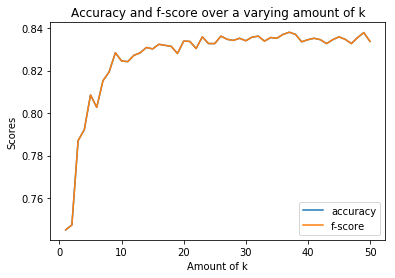

In [52]:
plt.plot(K, acc)
plt.plot(K, f_score)
plt.legend(['accuracy','f-score'])
plt.xlabel('Amount of k')
plt.ylabel('Scores')
plt.title('Accuracy and f-score over a varying amount of k')
plt.show()